# Tensorflow-text-recognition

간단한 머신러닝을 사용해서 MNIST 사진들을 인식하기.  
머신러닝 알고리즘 자체는 너무나 간단한 Sequential API이지만,  
해당 알고리즘을 `opencv.js`와 `tensorflow.js`를 통해서 브라우저에 이식하는 것이 최종적인 목표이다.

# 라이브러리 로드

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import text_extract as text
import numpy as np
import sk_img
import json
import os
import re

# 파일 읽기 및 글자 분리

이 코드에서 사용한 opencv함수들은 다음과 같다.  
이때, opencv.js에 없는건 ~~취소선~~처리 되어있다.

**process.py**
* bitwise_not
* threshold
* dilate
* erode
* ~~fastNlMeansDenoising~~
* addWeighted
* getRotationMatrix2D
* warpAffine

**data.py**
* imread
* approxPolyDP
* boundingRect
* findContours
* minAreaRect
* ~~boxPoints~~

과정에서 핵심적인 `fastNlMeansDenoising`함수가 opencv.js에서 사용이 불가능함에 따라,  
다음과 같은 대안을 고려해 볼 수 있다.

* `fastNlMeansDenoising`함수 알고리즘을 직접 구현하기: 함수 원리 자체가 간단하긴 한데 직접 구현하려면 시간도 오래걸리고 난이도도 생각보다 높을 것 같다.
* 다른 방법으로 이미지의 노이즈를 제거하기: Smoothing계열 필터들을 사용해서 노이즈를 제거한 후 해당 결과를 이전 결과와 비교해 본다.

알고리즘에 관해서 아무것도 모르는 나는 그냥 후자를 선택해서 하는게 현명할 것 같다.

In [ ]:
JSON_PATH = "./settings.json"

with open(JSON_PATH) as f:
    settings = json.load(f)

file_settings = settings["file"]
file_names = text.data.get_file_names(file_settings)

image_array = []
h_crop_array = []
v_crop_array = []
h_max_size = 0
v_max_size = 0

for name in file_names:
    path = file_settings["path"]
    gray_img = text.data.read_image(path, name)

    rotate_img = text.extract.set_textbox_horizontally(gray_img, settings)
    textbox_img = text.extract.extract_textbox(rotate_img, settings)
    enhanced_img = text.extract.enhance_textbox(textbox_img, settings)

    char_crop_settings = settings["cropPoints"]
    [h_crop_points, h_max] = text.data.get_char_info(enhanced_img, char_crop_settings, mode="h")
    [v_crop_points, v_max] = text.data.get_char_info(enhanced_img, char_crop_settings, mode="v")

    image_array.append(enhanced_img)

    h_crop_array.append(h_crop_points)
    v_crop_array.append(v_crop_points)

    h_max_size = h_max if h_max > h_max_size else h_max_size
    v_max_size = v_max if v_max > v_max_size else v_max_size

# plt.imshow(image_array[0][:200, :200])
# plt.show()

In [ ]:
# FastNLDenoise와 Bilaterial필터 비교

import cv2

raw = text.data.read_image("./image/", "random-ascii.jpg")
raw = raw[200:300, 200:300]

invert = text.process.invert(raw)

kernel_size = 3
sigma_color = 75
sigma_space = 75
bilaterial = cv2.bilateralFilter(invert, kernel_size, sigma_color, sigma_space)
bi_contrast = text.process.contrast(bilaterial, 16)
denoise = text.process.denoise(invert, 30, 7, 21)


image_list = [invert, bilaterial, bi_contrast, denoise]
name_list = ["original", "bilaterial", "bi_contrast", "denoise"]

plt.figure(figsize=(8, 6))
plt.tight_layout()

for i in range(len(image_list)):
    plt.subplot(2, 2, i + 1)
    plt.axis("off")
    plt.imshow(image_list[i])
    plt.title(name_list[i])

plt.show()

## Scikit-image용 이미지 처리 코드
scikit image에서 `minAreaRect`함수를 지원하지 않아서 직접 Convex hull과 Rotating calipers 알고리즘을 작성해야 된다.

[[265.38420285 143.23706676]
 [ 67.26873404 107.98952937]
 [ 31.30704123 310.11904414]
 [229.42251003 345.36658154]]


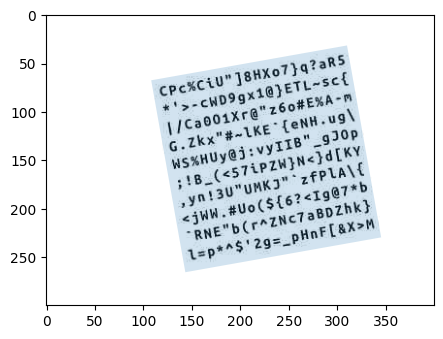

'\nplt.figure(figsize=(5,5))\nplt.imshow(dilate_img)\nplt.show()\n'

In [4]:
JSON_PATH = "./settings.json"

with open(JSON_PATH) as f:
    settings = json.load(f)

gray_img = sk_img.process.read("./image/sample-text.jpg")
binary_thresh = settings["binarization"]["thresh"]
binary_img = sk_img.process.binarization(gray_img, binary_thresh)

rotate_kernel_size = settings["dilation"]["kernel"]["toRotate"]
dilate_img = sk_img.process.dilation(binary_img, rotate_kernel_size)

main_contour = sk_img.data.get_main_contour(dilate_img)

rect_point = sk_img.data.calc_min_area_rect(main_contour)
print(rect_point)

plt.figure(figsize=(5,5))
plt.imshow(gray_img, cmap="gray")
plt.fill(rect_point[:,1], rect_point[:,0], alpha=0.2)
plt.show()

"""
plt.figure(figsize=(5,5))
plt.imshow(dilate_img)
plt.show()
"""

# 데이터 변환하기

여러 이미지가 input으로 와도 적용이 가능하도록 모듈 수정하기  
`Tensorflow.js`에서 어떻게 할지 제일 고민이 많이 되는 부분이다.  
JS에는 numpy가 없기 때문에...  
가능만 하다면 `Tensorflow.js`의 내장기능을 활용해야 할 것 같다.

In [ ]:
# create empty data

text_len = (len(v_crop_array[0]) - 1) * (len(h_crop_array[0]) - 1)
char_array = np.zeros((text_len, v_max_size, h_max_size), dtype=image_array[0].dtype)

char_idx = 0
for v_idx in range(len(v_crop_array[0]) - 1):
    for h_idx in range(len(h_crop_array[0]) - 1):
        empty_img = np.zeros((v_max_size, h_max_size), dtype=image_array[0].dtype)
        v_start = v_crop_array[0][v_idx]
        h_start = h_crop_array[0][h_idx]
        v_next = v_crop_array[0][v_idx + 1]
        h_next = h_crop_array[0][h_idx + 1]
        char_img = image_array[0][v_start:v_next, h_start:h_next]

        empty_img[:char_img.shape[0], :char_img.shape[1]] = char_img
        char_array[char_idx, :, :] = empty_img
        char_idx += 1

text_array = text.seed_random.make_random_text(1, text_len)

# for i in range(20):
#     plt.figure(figsize=(0.5, 0.5))
#     plt.imshow(char_array[i, :, :])
#     plt.show()

In [ ]:
char_array.shape

# 머신러닝

와! 텐서플로우! 와! MLP!  
날먹이 이렇게 쉽습니다 여러분.  
앞에서는 장대하게 데이터 추출한 다음에 정작 머신러닝 코드는 핸즈온 머신러닝 베껴쓰는 이게 진정한 용두사미 아닐까...?

## CNN 사용 모델

In [ ]:
import tensorflow as tf
from tensorflow import keras

X_train_full = char_array
y_train_full = text_array

X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

output_len = 0x7F - 0x21

model = keras.models.Sequential([
    keras.layers.Conv2D(16, 3, activation="relu", padding="same", input_shape=[v_max_size, h_max_size, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(output_len, activation="softmax")
])

# model.summary()

# model.compile(
#     loss=keras.losses.sparse_categorical_crossentropy,
#     optimizer=keras.optimizers.SGD(),
#     metrics=[keras.metrics.sparse_categorical_accuracy],
# )

model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))


## MLP 사용 모델

In [ ]:
import tensorflow as tf
from tensorflow import keras

X_train_full = char_array
y_train_full = text_array

X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

output_len = 0x7F - 0x21

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[v_max_size, h_max_size]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(output_len, activation="softmax")
])

# model.summary()

# model.compile(
#     loss=keras.losses.sparse_categorical_crossentropy,
#     optimizer=keras.optimizers.SGD(),
#     metrics=[keras.metrics.sparse_categorical_accuracy],
# )

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))


In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()